In [1]:
import pickle
import rospy
import baxter_interface
import os.path as path
import copy
from tqdm import tqdm_notebook as tqdmn
import matplotlib.pyplot as plt
import itertools

In [2]:
# initialize ros node
rospy.init_node('trajectory_player')
limb = baxter_interface.Limb('right')

In [3]:
# define relevant variables
PLAYBACK_MODE = 'bend'
file_seed = path.expanduser('~/data/moveit_data/')
if PLAYBACK_MODE == 'bend':
    file_seed = file_seed + 'bend_dof_'
else:
    file_seed = file_seed + 'full_dof_'

In [4]:
# in a loop load all the plans and replay
joint_angles = {}
# observations = []
for file_iter in tqdmn(xrange(2), desc='Files read:'):
    plan = pickle.load(open(file_seed + str(file_iter) + '.pkl', 'rb'))
    ctr = 0
    err = {'s1':[], 'e1': [], 'w1':[]}
    obs = []
    for ctr in tqdmn(xrange(len(plan)), desc='Waypoints achieved:'):
        if ctr == 0:
            joint_names = copy.deepcopy(plan[ctr])
            print joint_names
        else:
            for (i, joint) in enumerate(joint_names):
                joint_angles[joint] = plan[ctr][i]
            if ctr == 1:
                current_velocities = limb.joint_velocities()
                current_torques = limb.joint_efforts()
                limb.move_to_joint_positions(joint_angles)
            else:
                current_velocities = limb.joint_velocities()
                current_torques = limb.joint_efforts()
                limb.set_joint_positions(joint_angles)
                rospy.sleep(0.1)
            measured_angles = limb.joint_angles()
            err['e1'].append(abs(measured_angles['right_e1']-joint_angles['right_e1']))
            err['s1'].append(abs(measured_angles['right_s1']-joint_angles['right_s1']))
            err['w1'].append(abs(measured_angles['right_w1']-joint_angles['right_w1']))
            # append all dicts to a list
#     observations.append(obs)


['right_s0', 'right_s1', 'right_e0', 'right_e1', 'right_w0', 'right_w1', 'right_w2']



NameError: name 'observations' is not defined

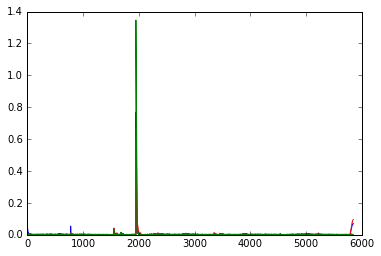

In [5]:
xaxis = xrange(len(plan)-1)
plt.plot(xaxis, err['e1'], 'b')
plt.plot(xaxis, err['s1'], 'r')
plt.plot(xaxis, err['w1'], 'g')
plt.show()